# About v5

this script use two images(6 * 3 * 640 * 480) as input of model. (two images as 6 channal)

1. original image size (640 * 480) 
2. mask (64 * 128) pasted at center of origin image and append to (640 * 480) 

In [1]:
from tqdm import tqdm
from models import CompletionNetwork, ContextDiscriminator, GlobalDiscriminator_P
from datasets_fullsize_v1 import ImageDataset
from losses import completion_network_loss, completion_network_loss_P
from noise import AddGaussianNoise
from utils import (
    gen_input_mask,
    gen_hole_area,
    crop,
    sample_random_batch,
    poisson_blend,
)
from torch.utils.data import DataLoader
from torch.optim import Adadelta, Adam
from torch.nn import BCELoss, DataParallel
from torchvision.utils import save_image
import torchvision.utils as vutils
from PIL import Image
import torchvision.transforms as transforms
import torch
import random
import os
import argparse
import numpy as np
import json
import time

import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
!pwd

/root/notebooks/final/pedestrian_generator


In [3]:
data_path = "/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000"

out_path = "/root/notebooks/pedestrian_generator_data/test_2"

In [4]:
sorted(glob.glob(data_path+'/people/*'), key=lambda x: x[-10:-3])[:10]

['/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000000.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000001.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000002.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000003.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000004.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000005.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000006.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000007.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000008.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000009.jpg']

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default=data_path)
parser.add_argument('--result_dir', type=str, default=out_path)
parser.add_argument('--recursive_search', action='store_true', default=False)
parser.add_argument('--init_model_cn', type=str, default=None)
parser.add_argument('--init_model_cd', type=str, default=None)
parser.add_argument('--steps_1', type=int, default=20000)
parser.add_argument('--steps_2', type=int, default=4000)
parser.add_argument('--steps_3', type=int, default=30000)
parser.add_argument('--snaperiod_1', type=int, default=5000)
parser.add_argument('--snaperiod_2', type=int, default=2000)
parser.add_argument('--snaperiod_3', type=int, default=5000)
parser.add_argument('--max_holes', type=int, default=1)
parser.add_argument('--hole_min_w', type=int, default=48)
parser.add_argument('--hole_max_w', type=int, default=96)
parser.add_argument('--hole_min_h', type=int, default=48)
parser.add_argument('--hole_max_h', type=int, default=96)
parser.add_argument('--cn_input_size', type=int, default=256)
parser.add_argument('--ld_input_size', type=int, default=256)
parser.add_argument('--optimizer', type=str, choices=['adadelta', 'adam'], default='adam')
parser.add_argument('--bsize', type=int, default=2)
parser.add_argument('--bdivs', type=int, default=1)
parser.add_argument('--data_parallel', action='store_true')
parser.add_argument('--num_test_completions', type=int, default=3)
parser.add_argument('--mpv', nargs=3, type=float, default=None)
parser.add_argument('--alpha', type=float, default=4e-3)
parser.add_argument('--arc', type=str, choices=['celeba', 'places2'], default='celeba')

parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [6]:
args = parser.parse_args()

In [7]:
# ================================================
# Preparation
# ================================================
args.data_dir = os.path.expanduser(args.data_dir)
args.result_dir = os.path.expanduser(args.result_dir)
if args.init_model_cn != None:
    args.init_model_cn = os.path.expanduser(args.init_model_cn)
if args.init_model_cd != None:
    args.init_model_cd = os.path.expanduser(args.init_model_cd)
if torch.cuda.is_available() == False:
    raise Exception('At least one gpu must be available.')
else:
    gpu = torch.device('cuda:0')

# create result directory (if necessary)
if os.path.exists(args.result_dir) == False:
    os.makedirs(args.result_dir)

    
#code below not used    
for s in ['phase_1', 'phase_2', 'phase_3']:
    if os.path.exists(os.path.join(args.result_dir, s)) == False:
        os.makedirs(os.path.join(args.result_dir, s))


In [8]:
# dataset
trnsfm = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 1.)
])

test_dset = ImageDataset(args.data_dir)
dataloader = DataLoader(test_dset, batch_size=64, shuffle=False)

In [9]:
transPIL = transforms.ToPILImage()

In [10]:
len(test_dset)

100000

In [11]:
timg = cv2.cvtColor(np.asarray(test_dset.__getitem__(100)[0]),cv2.COLOR_RGB2BGR)
print("Image size ",timg.shape)

Image size  (480, 640, 3)


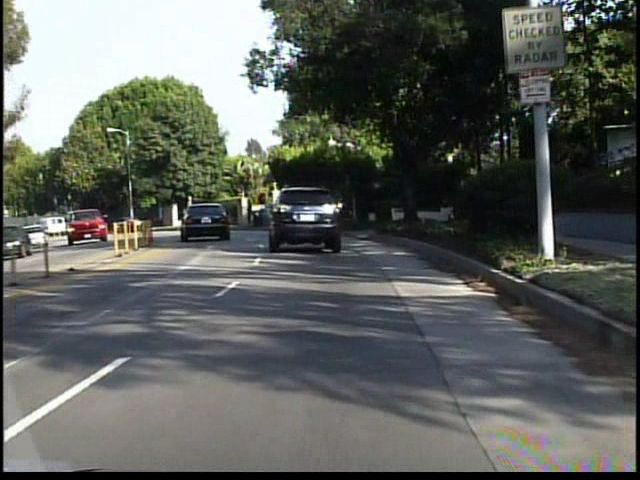

In [12]:
test_dset.__getitem__(10)[0]

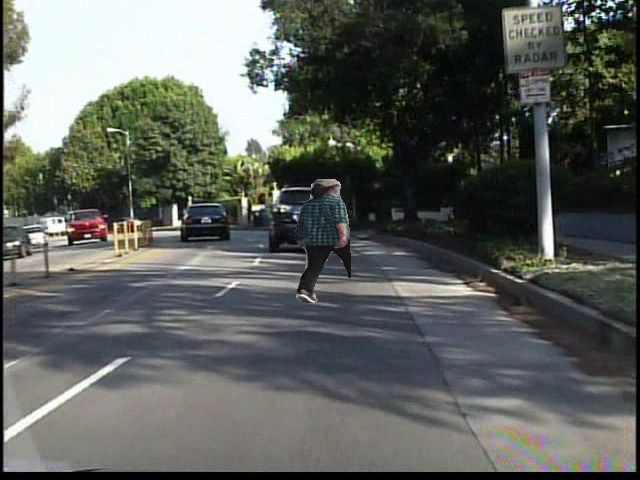

In [13]:
test_dset.__getitem__(10)[1]

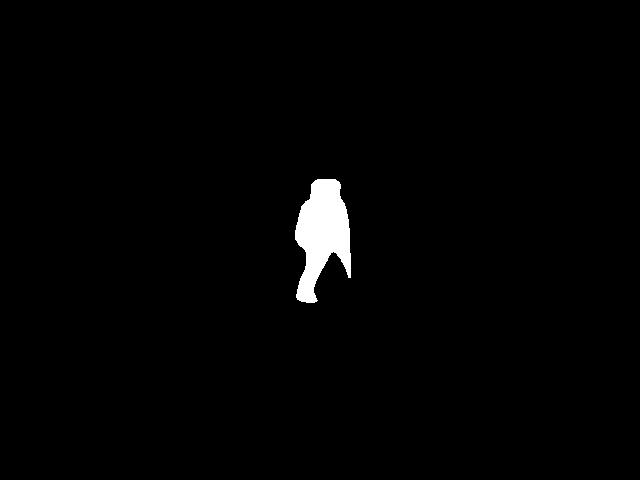

In [14]:
test_dset.__getitem__(10)[2]

In [15]:
test_dset.__getitem__(10)[3]

array([288, 176])

In [16]:
# dataset

trnsfm = transforms.Compose([
    transforms.ToTensor(),
    
])

trnsfm2 = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(0., 0.001)
])
print('loading dataset... (it may take a few minutes)')
train_dset = ImageDataset(args.data_dir, trnsfm,trnsfm2)
test_dset = ImageDataset(args.data_dir, trnsfm,trnsfm2)
train_loader = DataLoader(train_dset, batch_size=(args.bsize // args.bdivs), shuffle=True, num_workers=5)


alpha = torch.tensor(args.alpha).to(gpu)

loading dataset... (it may take a few minutes)


In [17]:
# print(train_dset.__getitem__(0)[0].size())
# print(type(train_dset.__getitem__(0)[0]))
# print(train_dset.__getitem__(0)[1].size())
# print(train_dset.__getitem__(0)[2])

In [18]:
print(iter(train_loader).next()[0].size())
print(iter(train_loader).next()[1].size())
print(iter(train_loader).next()[2].size())
print(torch.cat((iter(train_loader).next()[0], iter(train_loader).next()[1]), dim=1).size())

torch.Size([2, 3, 480, 640])
torch.Size([2, 3, 480, 640])
torch.Size([2, 3, 480, 640])
torch.Size([2, 6, 480, 640])


In [19]:
# Create model G

model_cn = CompletionNetwork()
if args.data_parallel:
    model_cn = DataParallel(model_cn)
if args.init_model_cn != None:
    model_cn.load_state_dict(torch.load(args.init_model_cn, map_location='cpu'))
if args.optimizer == 'adadelta':
    opt_cn = Adadelta(model_cn.parameters(), lr=0.8)
else:
    opt_cn = Adam(model_cn.parameters())
model_cn = model_cn.to(gpu)

# Create model D
model_cd = GlobalDiscriminator_P((3, 640, 480))

if args.data_parallel:
    model_cd = DataParallel(model_cd)
if args.init_model_cd != None:
    model_cd.load_state_dict(torch.load(args.init_model_cd, map_location='cpu'))
if args.optimizer == 'adadelta':
    opt_cd = Adadelta(model_cd.parameters(), lr=0.8)
else:
    opt_cd = Adam(model_cd.parameters())
model_cd = model_cd.to(gpu)
bceloss = BCELoss()

In [20]:
#model_cd = GlobalDiscriminator_P((3, 640, 480))

In [21]:
def train_G(n,steps):
    cnt_bdivs = 0
    pbar = tqdm(total=steps)
    while pbar.n < steps:
        for street_img, mask_poeple, mask, left_top in train_loader:
            street_img = street_img.to(gpu)
            mask_poeple = mask_poeple.to(gpu)
            mask = mask.to(gpu)
            
            #print(street_img.shape)
            #print(mask_poeple.shape)
            #print(mask.shape)

            input = torch.cat((street_img, mask_poeple), dim=1)
            output = model_cn(input)
            #loss = completion_network_loss(x, output, mask)
            #loss = torch.nn.functional.mse_loss(output, street_img)
            
            loss = completion_network_loss_P(street_img, mask_poeple, mask, output, left_top,height = 128 , width = 64)

            # backward
            loss.backward()
            cnt_bdivs += 1
            
            #print(output.shape)

            if cnt_bdivs >= args.bdivs:
                cnt_bdivs = 0
                # optimize
                opt_cn.step()
                # clear grads
                opt_cn.zero_grad()
                # update progbar
                pbar.set_description('%d | phase 1 | train loss: %.5f' % (n,loss.cpu()))
                pbar.update()
                if pbar.n % args.snaperiod_1 == 0:
                #if 1:
                    with torch.no_grad():
                        x1, x2, x3 = sample_random_batch(test_dset, batch_size=3)
                        x1 = x1.to(gpu)
                        x2 = x2.to(gpu)
                        x3 = (x3).le(0.5).to(torch.uint8) * 255

                        input = torch.cat((x1, x2), dim=1)
                        output = model_cn(input)
                        completed = poisson_blend(output, x1, x3)
                        imgs = torch.cat((x1.cpu(), x2.cpu(), output.cpu(),completed.cpu()), dim=2)
                        imgpath = os.path.join(args.result_dir, 'phase_1', '%d_step%d.png' % (n , pbar.n))
                        model_cn_path = os.path.join(args.result_dir, 'phase_1', '%d_model_cn_step%d' % (n , pbar.n))
                        save_image(imgs, imgpath, nrow=len(x1))
                        if args.data_parallel:
                            torch.save(model_cn.module.state_dict(), model_cn_path)
                        else:
                            torch.save(model_cn.state_dict(), model_cn_path)
                # terminate
                if pbar.n >= steps:
                    break
    pbar.close()


In [22]:
#train_G(1,200)

In [23]:
def train_D(n,steps):
    cnt_bdivs = 0
    pbar = tqdm(total=steps)
    while pbar.n < steps:
        for street_img, mask_poeple, _, _ in train_loader:

            # fake forward
            street_img = street_img.to(gpu)
            mask_poeple = mask_poeple.to(gpu)

            fake = torch.zeros((len(street_img), 1)).to(gpu)

            input_cn = torch.cat((street_img, mask_poeple), dim=1)
            output_cn = model_cn(input_cn)

            input_gd_fake = output_cn.detach()
            output_fake = model_cd(input_gd_fake.to(gpu))
            loss_fake = bceloss(output_fake, fake)

            # real forward
            real = torch.ones((len(street_img), 1)).to(gpu)
            input_gd_real = street_img
            output_real = model_cd(input_gd_real.to(gpu))
            loss_real = bceloss(output_real, real)

            # reduce
            loss = (loss_fake + loss_real) / 2.

            # backward
            loss.backward()
            cnt_bdivs += 1

            if cnt_bdivs >= args.bdivs:
                cnt_bdivs = 0
                # optimize
                opt_cd.step()
                # clear grads
                opt_cd.zero_grad()
                # update progbar
                pbar.set_description('%d | phase 2 | train loss: %.5f' % (n,loss.cpu()))
                pbar.update()
                # test
                if pbar.n % args.snaperiod_2 == 0:
                    with torch.no_grad():
                        x1, x2, x3 = sample_random_batch(test_dset, batch_size=3)
                        x1 = x1.to(gpu)
                        x2 = x2.to(gpu)
                        x3 = (x3).le(0.5).to(torch.uint8) * 255

                        input = torch.cat((x1, x2), dim=1)
                        output = model_cn(input)
                        completed = poisson_blend(output, x1, x3)
                        
                        imgs = torch.cat((x1.cpu(), x2.cpu(), output.cpu(),completed.cpu()), dim=2)
                        imgpath = os.path.join(args.result_dir, 'phase_2', '%d_step%d.png' % (n , pbar.n))
                        model_cd_path = os.path.join(args.result_dir, 'phase_2', '%d_model_cn_step%d' % (n , pbar.n))
                        save_image(imgs, imgpath, nrow=len(x1))
                        if args.data_parallel:
                            torch.save(model_cd.module.state_dict(), model_cd_path)
                        else:
                            torch.save(model_cd.state_dict(), model_cd_path)
                # terminate
                if pbar.n >= steps:
                    break
    pbar.close()

In [24]:
# train_D(1,11)

In [25]:
def train_DG(n, steps):
    cnt_bdivs = 0
    pbar = tqdm(total=steps)
    while pbar.n < steps:
        for street_img, mask_poeple, mask, left_top in train_loader:

            # fake forward
            street_img = street_img.to(gpu)
            mask_poeple = mask_poeple.to(gpu)
            mask = mask.to(gpu)

            fake = torch.zeros((len(street_img), 1)).to(gpu)
            input_cn = torch.cat((street_img, mask_poeple), dim=1)
            output_cn = model_cn(input_cn)

            input_gd_fake = output_cn.detach()
            output_fake = model_cd(input_gd_fake.to(gpu))
            loss_cd_fake = bceloss(output_fake, fake)

            # real forward
            real = torch.ones((len(street_img), 1)).to(gpu)
            input_gd_real = street_img
            output_real = model_cd(input_gd_real.to(gpu))
            loss_cd_real = bceloss(output_real, real)

            # reduce
            loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.

            # backward model_cd
            loss_cd.backward()


            cnt_bdivs += 1
            if cnt_bdivs >= args.bdivs:
                # optimize
                opt_cd.step()
                # clear grads
                opt_cd.zero_grad()

            # forward model_cn
            #loss_cn_1 = torch.nn.functional.mse_loss(output_cn, street_img)
            loss_cn_1 = completion_network_loss_P(street_img, mask_poeple, mask, output_cn, left_top,height = 128 , width = 64)
            input_gd_fake = output_cn
            output_fake = model_cd(input_gd_fake.to(gpu))
            loss_cn_2 = bceloss(output_fake, real)

            # reduce
            loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.

            # backward model_cn
            loss_cn.backward()

            if cnt_bdivs >= args.bdivs:
                cnt_bdivs = 0
                # optimize
                opt_cn.step()
                # clear grads
                opt_cn.zero_grad()
                # update progbar
                pbar.set_description('%d | phase 3 | train loss (cd): %.5f (cn): %.5f' % (n, loss_cd.cpu(), loss_cn.cpu()))
                pbar.update()
                # test
                if pbar.n % args.snaperiod_3 == 0:
                    with torch.no_grad():
                        x1, x2, x3 = sample_random_batch(test_dset, batch_size=3)
                        x1 = x1.to(gpu)
                        x2 = x2.to(gpu)
                        x3 = (x3).le(0.5).to(torch.uint8) * 255
                        
                        input = torch.cat((x1, x2), dim=1)
                        output = model_cn(input)
                        completed = poisson_blend(output, x1, x3)
                        imgs = torch.cat((x1.cpu(), x2.cpu(), output.cpu(),completed.cpu()), dim=2)

                        imgpath = os.path.join(args.result_dir, 'phase_3', '%d_step%d.png' % (n, pbar.n))

                        model_cn_path = os.path.join(args.result_dir, 'phase_3', '%d_model_cn_step%d' % (n , pbar.n))
                        model_cd_path = os.path.join(args.result_dir, 'phase_3', '%d_model_cd_step%d' % (n , pbar.n))
                        save_image(imgs, imgpath, nrow=len(x1))
                        if args.data_parallel:
                            torch.save(model_cn.module.state_dict(), model_cn_path)
                            torch.save(model_cd.module.state_dict(), model_cd_path)
                        else:
                            torch.save(model_cn.state_dict(), model_cn_path)
                            torch.save(model_cd.state_dict(), model_cd_path)
                # terminate
                if pbar.n >= steps:
                    break
    pbar.close()

In [26]:
# train_DG(1,10)

In [27]:
train_G(1,10000)

1 | phase 1 | train loss: 0.00591: 100%|██████████| 10000/10000 [1:08:07<00:00,  2.45it/s]


In [28]:
train_D(1,4000)

1 | phase 2 | train loss: 13.81551: 100%|██████████| 4000/4000 [27:54<00:00,  2.39it/s]  


In [29]:
train_DG(1,20000)

1 | phase 3 | train loss (cd): 0.05526 (cn): 0.00116: 100%|██████████| 20000/20000 [4:36:48<00:00,  1.20it/s]   


In [30]:
# part2

In [31]:
#train_G(2,500)

In [32]:
#train_D(2,200)

In [33]:
#train_DG(2,800)

In [34]:
Image.open("/root/notebooks/pedestrian_generator_data/test_2/phase_3/1_step3_20000.png")

FileNotFoundError: [Errno 2] No such file or directory: '/root/notebooks/pedestrian_generator_data/test_2/phase_3/1_step3=20000.png'